In [ ]:
pip install langgraph-supervisor langchain-openai langsmith python-dotenv

In [66]:

import os
from dotenv import load_dotenv

load_dotenv(dotenv_path=".env", override=True)
# print(os.getenv("OPENAI_API_KEY"))
# print(os.getenv("LANGCHAIN_API_KEY"))
# print(os.getenv("LANGCHAIN_PROJECT"))
# print(os.getenv("LANGCHAIN_TRACING_V2"))

False

In [67]:
from langsmith import utils
utils.tracing_is_enabled()

True

In [ ]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(model="gpt-4o")

In [ ]:
def pretty_print_message(message, indent=False):
    pretty_message = message.pretty_repr(html=True)
    if not indent:
        print(pretty_message)
        return

    indented = "\n".join("\t" + c for c in pretty_message.split("\n"))
    print(indented)

In [45]:
from langchain_core.messages import convert_to_messages



def pretty_print_messages(update, last_message=False):
    is_subgraph = False
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")
        is_subgraph = True

    for node_name, node_update in update.items():
        update_label = f"Update from node {node_name}:"
        if is_subgraph:
            update_label = "\t" + update_label

        print(update_label)
        print("\n")

        messages = convert_to_messages(node_update["messages"])
        if last_message:
            messages = messages[-1:]

        for m in messages:
            pretty_print_message(m, indent=is_subgraph)
        print("\n")

In [54]:
def add(a: float, b: float):
    """Add two numbers."""
    return a + b


def multiply(a: float, b: float):
    """Multiply two numbers."""
    return a * b


def divide(a: float, b: float):
    """Divide two numbers."""
    return a / b

def web_search(query: str) -> str:
    """Search the web for information."""
    return (
        "Here are the headcounts for each of the FAANG companies in 2024:\n"
        "1. **Facebook (Meta)**: 67,317 employees.\n"
        "2. **Apple**: 164,000 employees.\n"
        "3. **Amazon**: 1,551,000 employees.\n"
        "4. **Netflix**: 14,000 employees.\n"
        "5. **Google (Alphabet)**: 181,269 employees."
    )

In [47]:
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent


In [55]:
math_agent = create_react_agent(
    model=model,
    tools=[add, multiply, divide],
    prompt=(
        "You are a math agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with math-related tasks\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="math_agent",
)

In [59]:
for chunk in math_agent.stream(
    {"messages": [{"role": "user", "content": "what's (3 + 5) x 7"}]}
):
    pretty_print_messages(chunk)

Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  add (call_ODKOP8At2HSYmKK7lCoXOXYE)
 Call ID: call_ODKOP8At2HSYmKK7lCoXOXYE
  Args:
    a: 3
    b: 5


Update from node tools:


================================= Tool Message =================================
Name: add

8.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent
Tool Calls:
  multiply (call_C1Gffzb9RvXqZ0c9X4r27M6h)
 Call ID: call_C1Gffzb9RvXqZ0c9X4r27M6h
  Args:
    a: 8
    b: 7


Update from node tools:


================================= Tool Message =================================
Name: multiply

56.0


Update from node agent:


================================== Ai Message ==================================
Name: math_agent

56




In [ ]:
research_agent = create_react_agent(
    model=model,
    tools=[web_search],
    prompt=(
        "You are a research agent.\n\n"
        "INSTRUCTIONS:\n"
        "- Assist ONLY with research-related tasks, DO NOT do any math\n"
        "- After you're done with your tasks, respond to the supervisor directly\n"
        "- Respond ONLY with the results of your work, do NOT include ANY other text."
    ),
    name="research_agent",
)

In [60]:
for chunk in research_agent.stream(
    {"messages": [{"role": "user", "content": "Head count in faang"}]}
):
    pretty_print_messages(chunk)


Update from node agent:


================================== Ai Message ==================================
Name: research_expert
Tool Calls:
  web_search (call_ChO0QqJgRGfxReuzWBUbyDzz)
 Call ID: call_ChO0QqJgRGfxReuzWBUbyDzz
  Args:
    query: current head count Facebook 2023
  web_search (call_ezL92F6WEVrH8kEoZAMnLZJg)
 Call ID: call_ezL92F6WEVrH8kEoZAMnLZJg
  Args:
    query: current head count Apple 2023
  web_search (call_0urq4m3JeIVh87wZXF6dqYle)
 Call ID: call_0urq4m3JeIVh87wZXF6dqYle
  Args:
    query: current head count Amazon 2023
  web_search (call_0YjD5wP3w10cWJn1bX7K0jcD)
 Call ID: call_0YjD5wP3w10cWJn1bX7K0jcD
  Args:
    query: current head count Netflix 2023
  web_search (call_TGStQEbFZlTomWFOD6XVJxwE)
 Call ID: call_TGStQEbFZlTomWFOD6XVJxwE
  Args:
    query: current head count Google 2023


Update from node tools:


================================= Tool Message =================================
Name: web_search

Here are the headcounts for each of the FAANG companies

In [61]:
# Create supervisor workflow
math_search_workflow = create_supervisor(
    [research_agent, math_agent],
    model=model,
    prompt=(
        "You are a supervisor managing two agents:\n"
        "- a research agent. Assign research-related tasks to this agent\n"
        "- a math agent. Assign math-related tasks to this agent\n"
        "Assign work to one agent at a time, do not call agents in parallel.\n"
        "Do not do any work yourself."
    ),
    add_handoff_back_messages=True,
    output_mode="full_history",

)


In [64]:
app = math_search_workflow.compile()
for chunk in app.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": "What is the combined employee headcount of the FAANG companies (Facebook, Apple, Amazon, Netflix, Google) in 2024?",
            }
        ]
    },
):
    pretty_print_messages(chunk, last_message=True)

final_message_history = chunk["supervisor"]["messages"]

Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_research_expert

Successfully transferred to research_expert


Update from node research_expert:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================= Tool Message =================================
Name: transfer_to_math_agent

Successfully transferred to math_agent


Update from node math_agent:


================================= Tool Message =================================
Name: transfer_back_to_supervisor

Successfully transferred back to supervisor


Update from node supervisor:


================================== Ai Message ==================================
Name: supervisor

The combined employee headcount of the FAANG companies (Facebook, Apple, Amazon, Netflix, Google) in 20

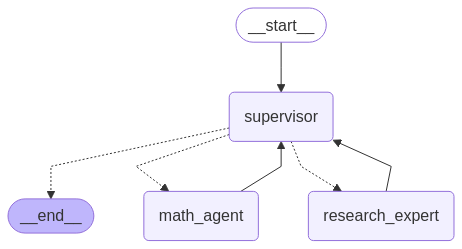

In [63]:
from IPython.display import display, Image
app = math_search_workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))